#### Conditional_VAEで教師データは全て使用している。semi supervisedではない。

In [1]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


#### library　version

In [1]:
import pkg_resources
for dist in pkg_resources.working_set:
    print(dist.project_name, dist.version)

zict 0.1.3
xlwt 1.3.0
XlsxWriter 1.0.4
xlrd 1.1.0
wrapt 1.10.11
widgetsnbextension 3.2.1
wheel 0.31.1
Werkzeug 0.14.1
webencodings 0.5.1
wcwidth 0.1.7
urllib3 1.22
unicodecsv 0.14.1
typing 3.6.4
traitlets 4.3.2
tqdm 4.25.0
tornado 5.0.2
toolz 0.9.0
testpath 0.3.1
terminado 0.8.1
termcolor 1.1.0
tensorflow 1.10.1
tensorboard 1.10.0
tblib 1.3.2
tables 3.4.3
sympy 1.1.1
statsmodels 0.9.0
SQLAlchemy 1.2.7
spyder 3.2.8
sphinxcontrib-websupport 1.0.1
Sphinx 1.7.4
sortedcontainers 1.5.10
sortedcollections 0.6.1
snowballstemmer 1.2.1
six 1.11.0
singledispatch 3.4.0.3
simplegeneric 0.8.1
setuptools 39.1.0
Send2Trash 1.5.0
seaborn 0.8.1
scipy 1.1.0
scikit-learn 0.19.1
scikit-image 0.13.1
ruamel-yaml 0.15.35
rope 0.10.7
requests 2.18.4
QtPy 1.4.1
qtconsole 4.3.1
QtAwesome 0.4.4
pyzmq 17.0.0
PyYAML 3.12
PyWavelets 0.5.2
pytz 2018.4
python-dateutil 2.7.3
pytest 3.5.1
pytest-remotedata 0.2.1
pytest-openfiles 0.3.0
pytest-doctestplus 0.1.3
pytest-astropy 0.3.0
pytest-arraydiff 0.2
PySocks 1.6.8
pypar

#### load mnist data

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

#### one-hot encoded vectors

In [4]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

#### setting Hyperparamaters

In [6]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(lr=0.001)

n_x = X_train.shape[1]
n_y = y_train.shape[1]

n_epoch = 50

#### Graph

In [7]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

#### 画像とラベルを結合させて入力している。

In [8]:
inputs = concat([X, label])

#### Encoder

In [9]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [10]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

In [11]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

#### 潜在変数とラベルを結合させる。
zc = concat([z, label])

#### Decoder

In [12]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [14]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [15]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)


#### Compile

In [16]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

#### Fitting

In [17]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                            validation_data = ([X_test, y_test], X_test),
                            callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 177us/step - loss: 198.9830 - KL_loss: 9.2695 - recon_loss: 189.7135 - val_loss: 157.4739 - val_KL_loss: 4.4714 - val_recon_loss: 153.0025
Epoch 2/50
60000/60000 [==============================] - 7s 109us/step - loss: 150.5621 - KL_loss: 4.2591 - recon_loss: 146.3030 - val_loss: 145.4496 - val_KL_loss: 4.2143 - val_recon_loss: 141.2353
Epoch 3/50
60000/60000 [==============================] - 7s 119us/step - loss: 143.8578 - KL_loss: 4.2606 - recon_loss: 139.5972 - val_loss: 141.7186 - val_KL_loss: 4.3148 - val_recon_loss: 137.4038
Epoch 4/50
60000/60000 [==============================] - 9s 144us/step - loss: 140.9894 - KL_loss: 4.2923 - recon_loss: 136.6971 - val_loss: 139.7711 - val_KL_loss: 4.1727 - val_recon_loss: 135.5984
Epoch 5/50
60000/60000 [==============================] - 12s 205us/step - loss: 139.2769 - KL_loss: 4.3091 - recon_loss: 134.9678 - val_loss: 138.72

#### raw Data

5


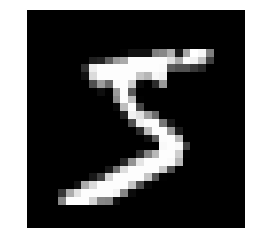

In [20]:
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
print(Y_train[0])

#### Prerdict

In [18]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[-0.35764307 -0.06518018]]


#### 潜在変数のマッピング

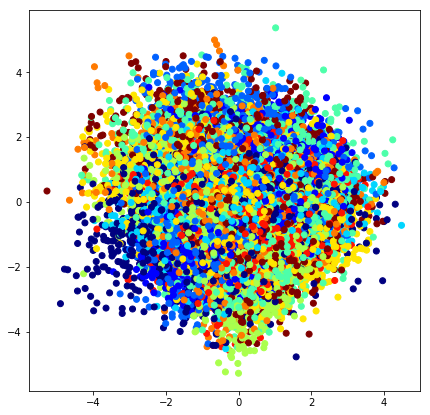

In [19]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet);

#### 潜在変数のマッピング　（0～1バラバラ）

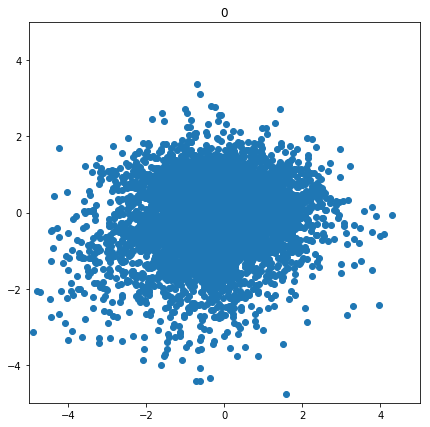

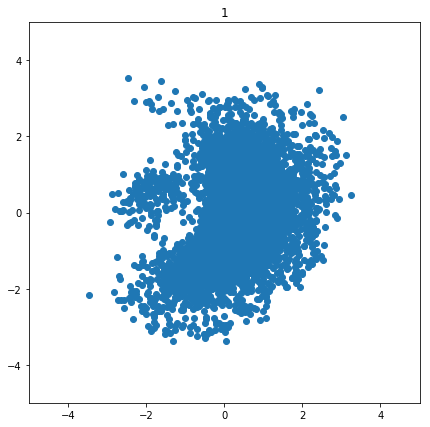

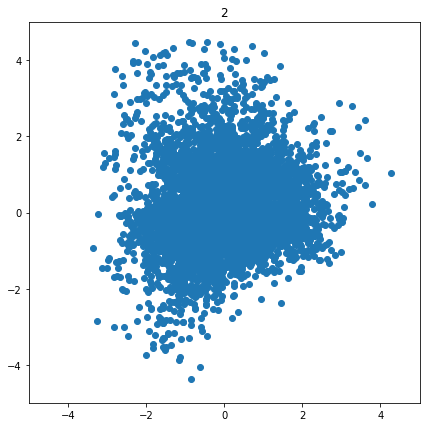

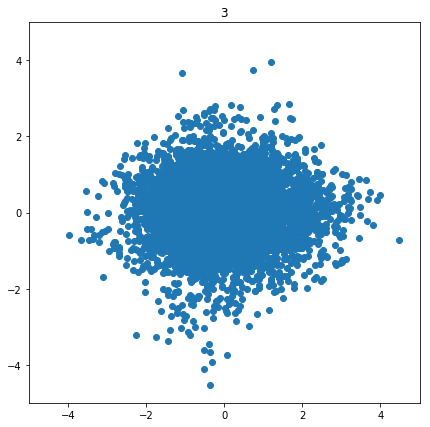

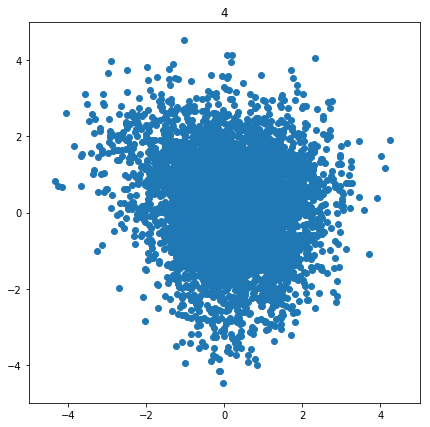

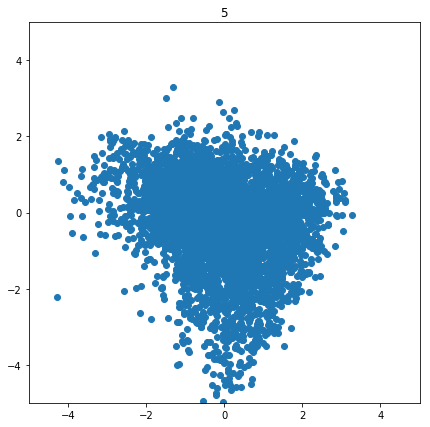

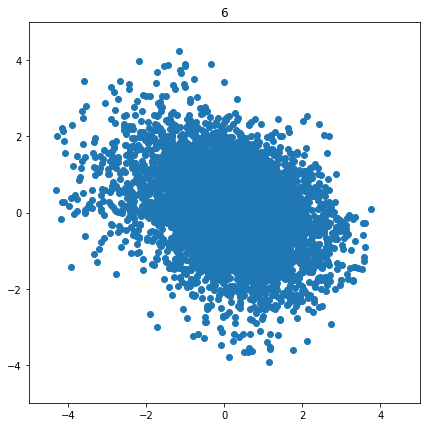

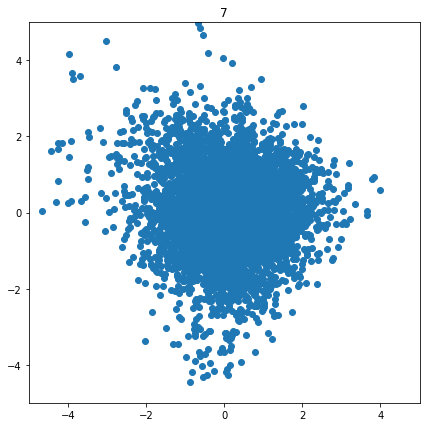

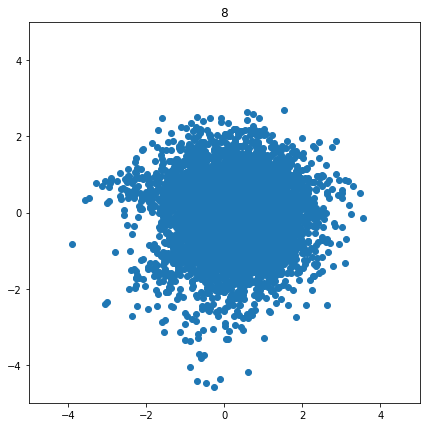

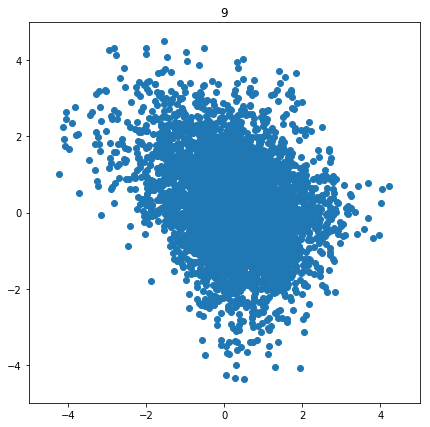

In [50]:
for label_ in range(10):
    y_train_per = y_train[Y_train==label_]
    X_train_per = X_train[Y_train==label_]
    z_train_per = encoder.predict([X_train_per, y_train_per])
    encodings= np.asarray(z_train_per)
    encodings = encodings.reshape(X_train_per.shape[0], n_z)
    plt.figure(figsize=(7, 7))
    
    plt.scatter(encodings[:, 0], encodings[:, 1])#, cmap=plt.cm.jet);
    plt.title(label_)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

#### Decoderを使って画像生成
#### 左の2つは潜在変数　Z　で、右の10個はラベル

In [51]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


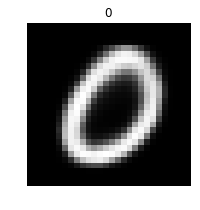

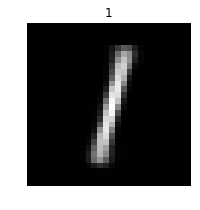

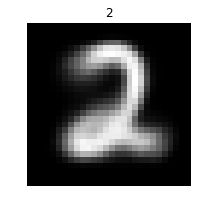

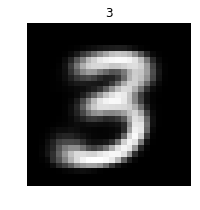

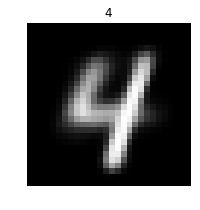

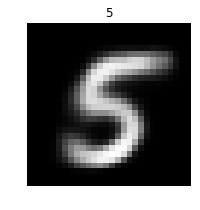

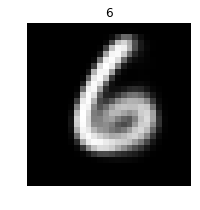

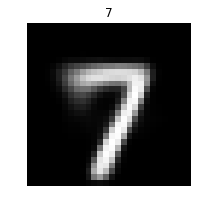

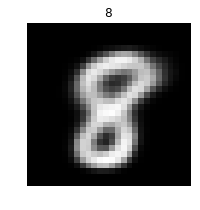

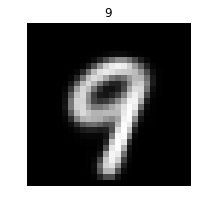

In [54]:
for label_ in range(10):
    sample_ = construct_numvec(label_)
    plt.figure(figsize=(3, 3))
    plt.imshow(decoder.predict(sample_).reshape(28,28), cmap = plt.cm.gray), axis('off')
    plt.title(label_)

#### 数字を固定して、筆記styleをサンプル

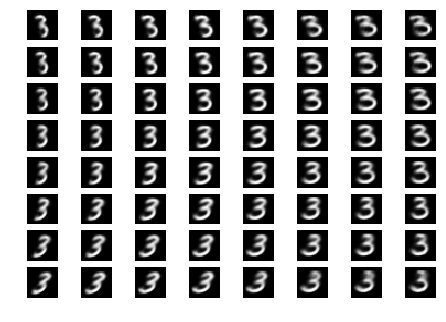

In [26]:
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)

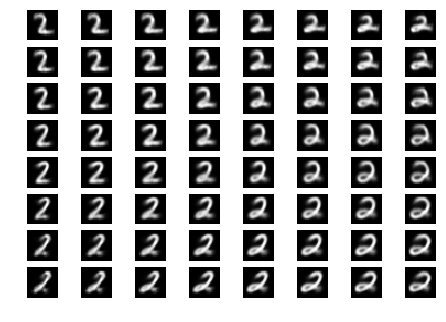

In [27]:
dig = 2
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)

#### 筆記styleサンプルを固定して、数字をサンプル

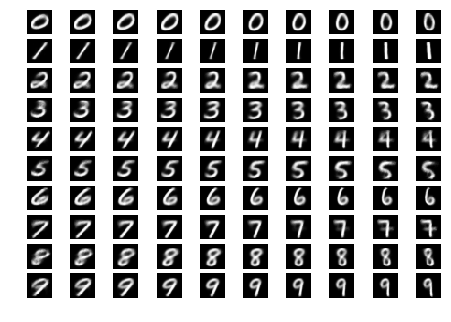

In [60]:
max_z = 1.5
img_it = 0

# label = 数字
# z　= 筆記style

for label_ in range(10):
   
    for j in range(10):
        z1 = (((j / (10-1)) * max_z)*2) - max_z
        z2 = (((j / (10-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(label_, z_)
        decoded = decoder.predict(vec)
        subplot(10, 10, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)